In [621]:
import pickle
import numpy as np
import pickle 

# For 3-states

In [622]:
# Load CTMC from files
with open('ctmc_ctrl_models.pkl', 'rb') as f:
    ctmc_ctrl_models = pickle.load(f)

with open('ctmc_cvi_models.pkl', 'rb') as f:
    ctmc_cvi_models = pickle.load(f)

print(ctmc_cvi_models['1044_4'])

In [624]:
cvi_ids = list(set([i.split('_')[0] for i in list(ctmc_cvi_models.keys())]))
ctrl_ids = list(set([i.split('_')[0] for i in list(ctmc_ctrl_models.keys())]))
ctrl_ids.sort()
cvi_ids.sort()

train_ids = ctrl_ids[:-5] + cvi_ids[:-5]
train_labels = [0] * len(ctrl_ids[:-5]) + [1] * len(cvi_ids[:-5])

test_ids = ctrl_ids[-5:] + cvi_ids[-5:]
test_labels = [0] * len(ctrl_ids[-5:]) + [1] * len(cvi_ids[-5:])

In [625]:
X =  ctrl_ids + cvi_ids
y = [0] * len(ctrl_ids) + [1] * len(cvi_ids)

In [626]:
def get_train_test_data_(ctmc_cvi_models, ctmc_ctrl_models, train_ids):
    featureofinterest = [1,2,4,6,8,9]#[0,1,2,3,5,6,7,8,9,10,11,12]
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for k in ctmc_cvi_models.keys():
        if(k.split('_')[0] in train_ids):
            X_train.append(ctmc_cvi_models[k].matrix.flatten()[featureofinterest].tolist())
            y_train.append(1)
        else:
            X_test.append(ctmc_cvi_models[k].matrix.flatten()[featureofinterest].tolist())
            y_test.append(1)

    for k in ctmc_ctrl_models.keys():
        if(k.split('_')[0] in train_ids):
            X_train.append(ctmc_ctrl_models[k].matrix.flatten()[featureofinterest].tolist())
            y_train.append(0)
        else:
            X_test.append(ctmc_ctrl_models[k].matrix.flatten()[featureofinterest].tolist())
            y_test.append(0)
    return X_train, y_train, X_test, y_test

In [627]:
from sklearn.base import BaseEstimator, ClassifierMixin

class dummiesclf(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        ret = np.ones(len(X))
        return ret
    
    def predict_proba(self, X, y=None):
        ret = np.stack([np.zeros(len(X)), np.ones(len(X))], axis=1)
        return ret
    
class meanclf(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        ret = np.ones(len(X))
        return ret
    
    def predict_proba(self, X, y=None):
        ret = np.stack([np.zeros(len(X)), np.ones(len(X))], axis=1)
        return ret

In [628]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# clf = LogisticRegression(random_state=1).fit(training_data, train_labels)

In [629]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

accuracys = []
f1_scores = []
sens_scores = []
spec_scores = []
rec_scores = []
skf = StratifiedKFold(n_splits=3)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    train_ids = np.array(X)[train_index]
    # train_labels = np.array(y)[train_index]
    test_ids = np.array(X)[test_index]
    # test_labels = np.array(y)[test_index]
    X_train, y_train, X_test, y_test = get_train_test_data(ctmc_cvi_models, ctmc_ctrl_models, train_ids)
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=100, tol=1e-3, alpha=0.01, class_weight={0:0.75, 1:0.25}, loss='modified_huber'))
    # clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
    # clf = make_pipeline(StandardScaler(), dummiesclf())
    # clf = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=10, random_state=0))
    model = clf.fit(X_train, y_train)

    accuracy = np.sum(clf.predict(X_test) == y_test)/len(y_test)
    cm = confusion_matrix(y_test, clf.predict(X_test))
    sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
    specificity = cm[0,0]/(cm[0,0] + cm[0,1])

    accuracys.append(accuracy)
    f1_scores.append(f1_score(clf.predict(X_test), y_test))
    sens_scores.append(sensitivity)
    spec_scores.append(specificity)
    # rec_scores.append(recall_score(clf.predict(X_test), y_test))
    rec_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    # print(np.sum(clf.predict(X_test) == y_test)/len(y_test))
    print(np.mean(accuracys), np.mean(f1_scores), np.mean(sens_scores), np.mean(spec_scores), np.mean(rec_scores))

0.7857142857142857 0.8571428571428572 0.9 0.5 0.9
0.7928571428571429 0.8541033434650456 0.8203703703703704 0.75 0.9048611111111111
0.7785714285714286 0.8396724992469672 0.7969135802469136 0.75 0.9011574074074075


In [630]:
print(np.mean(accuracys), np.mean(f1_scores), np.mean(sens_scores), np.mean(spec_scores), np.mean(rec_scores))

0.7785714285714286 0.8396724992469672 0.7969135802469136 0.75 0.9011574074074075


In [631]:
import shap
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(random_state=42)
explainer = shap.KernelExplainer(model.predict, np.array(X_test, dtype="float64"))
shap_values = explainer.shap_values(np.array(X_test, dtype="float64"))

100%|██████████| 28/28 [00:00<00:00, 244.87it/s]


In [632]:
# shap_test = explainer(np.array(X_test, dtype="float64"))

In [633]:
# feature_names = np.array(['INIT to INIT', 'INIT to FIX', 'INIT to SACC', 'INIT to BLINK',
# 'FIX to INIT', 'FIX to FIX', 'FIX to SACC', 'FIX to BLINK',
# 'SACC to INIT', 'SACC to FIX', 'SACC to SACC', 'SACC to BLINK',
# 'BLINK to INIT', 'BLINK to FIX', 'BLINK to SACC', 'BLINK to BLINK',])[[1,2,3,5,6,7,9,10,11,13,14]]
feat_name = ['fix','sacc','blink','init']
feature_names = []
for i in feat_name:
    for j in feat_name:
        feature_names.append(f'{i} to {j}')
featureofinterest = [1,2,4,6,8,9]#[0,1,2,3,5,6,7,8,9,10,11,12]
feature_names = np.array(feature_names)[featureofinterest]
feature_names

array(['fix to sacc', 'fix to blink', 'sacc to fix', 'sacc to blink',
       'blink to fix', 'blink to sacc'], dtype='<U14')

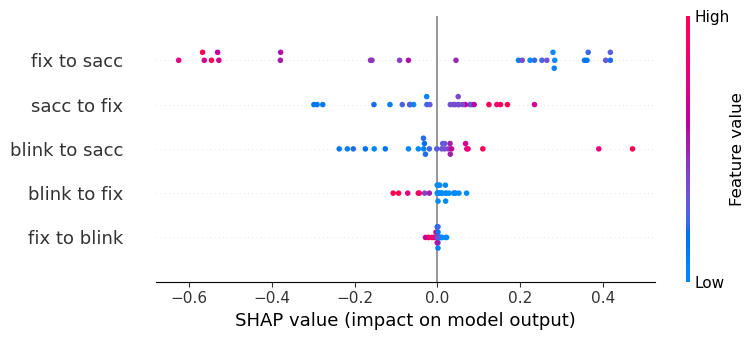

In [634]:
shap.summary_plot(shap_values, np.array(X_test, dtype="float64"), max_display=5, feature_names=feature_names, plot_type='dot')

# For 5-states

In [637]:
import pickle 
with open('ctmc_models.pkl', 'rb') as f:
    ctmc_models = pickle.load(f)
ctmc_models.keys()

dict_keys(['1003_2', '1003_3', '1003_4', '1004_2', '1005_1', '1006_1', '1006_2', '1006_3', '1006_4', '1007_1', '1007_2', '1007_3', '1007_4', '1008_1', '1010_1', '1010_2', '1010_3', '1010_4', '1011_1', '1011_2', '1011_3', '1013_1', '1013_2', '1013_3', '1013_4', '1015_1', '1015_2', '1017_1', '1017_2', '1017_3', '1017_4', '1018_1', '1018_2', '1018_3', '1018_4', '1019_2', '1019_3', '1019_4', '1020_1', '1020_2', '1020_3', '1020_4', '1022_1', '1022_2', '1022_3', '1022_4', '1023_1', '1023_2', '1023_3', '1023_4', '1024_1', '1024_2', '1024_3', '1026_1', '1027_1', '1027_2', '1027_3', '1027_4', '1028_1', '1028_2', '1028_3', '1030_1', '1031_1', '1031_2', '1031_3', '1031_4', '1034_1', '1034_2', '1035_1', '1035_4', '1037_1', '1037_4', '1039_1', '1039_2', '1039_3', '1039_4', '1040_1', '1040_4', '1042_1', '1042_2', '1042_3', '1042_4', '1043_1', '1043_2', '1043_3', '1044_1', '1044_2', '1044_4', '1045_2', '1045_3', '1045_4', '1046_1', '1046_2', '1046_3', '1046_4', '1047_2', '1047_3', '1048_1', '1048_2',

In [638]:
from sklearn.model_selection import train_test_split
ids = list(set([i.split('_')[0] for i in list(ctmc_models.keys())]))
yid = [(int(id) < 2000)*1 for id in ids]
ids_train, ids_test, yid_train, yid_test = train_test_split(ids, yid)

In [721]:
print(ctmc_models['1003_4'])

Name: CTMC_random_5_states
Initial state: s5
----STATE 0--saccade----
Exepected waiting time: 30.916666666666666666
s0 -> s1 : lambda = 0.008086253369272237197
s0 -> s2 : lambda = 0.020215633423180592991
s0 -> s3 : lambda = 0.0026954177897574123988
s0 -> s4 : lambda = 0.0013477088948787061994

----STATE 1--complex_scene_fixation----
Exepected waiting time: 233.71428571428571429
s1 -> s0 : lambda = 0.0024449877750611246944
s1 -> s3 : lambda = 0.0006112469437652811736
s1 -> s4 : lambda = 0.0012224938875305623472

----STATE 2--background_fixation----
Exepected waiting time: 279.125
s2 -> s0 : lambda = 0.0033587102552619794
s2 -> s1 : lambda = 0.00022391401701746529333

----STATE 3--face_fixation----
Exepected waiting time: 74.0
s3 -> s0 : lambda = 0.013513513513513513513

----STATE 4--blink----
Exepected waiting time: 108.666666666666666664
s4 -> s0 : lambda = 0.0030674846625766871166
s4 -> s1 : lambda = 0.0030674846625766871166
s4 -> s2 : lambda = 0.0030674846625766871166

----STATE 5--i

In [639]:
ctmc_models['1003_4'].matrix

array([[0.00000000e+00, 8.08625337e-03, 2.02156334e-02, 2.69541779e-03,
        1.34770889e-03, 0.00000000e+00],
       [2.44498778e-03, 0.00000000e+00, 0.00000000e+00, 6.11246944e-04,
        1.22249389e-03, 0.00000000e+00],
       [3.35871026e-03, 2.23914017e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.35135135e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.06748466e-03, 3.06748466e-03, 3.06748466e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.12500000e-01, 9.37500000e-02, 1.56250000e-01, 2.18750000e-01,
        2.18750000e-01, 0.00000000e+00]], dtype=float128)

In [640]:
[1,2,3,4,6,8,9,10,12,13,15,16,18,19,20,22,24,25,26,27]

[1, 2, 3, 4, 6, 8, 9, 10, 12, 13, 15, 16, 18, 19, 20, 22, 24, 25, 26, 27]

In [641]:
def get_train_test_from_ids(ctmc_models, ids_train, yid_train, ids_test, yid_test):
    featureofinterest = [1,2,3,4,6,8,9,10,12,13,15,16,18,19,20,22,24,25,26,27]#[i for i in range(29)]#[1,2,3,4,6,9,10,12,13,18,24,25,26]#
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for k in ctmc_models.keys():
        index = -1
        train = True
        try:
            index = ids_train.index(k.split('_')[0])
            train = True
        except:
            index = ids_test.index(k.split('_')[0])
            train = False
        if(train):
            X_train.append(ctmc_models[k].matrix.flatten()[featureofinterest].tolist())
            y_train.append(yid_train[index])
        else:
            X_test.append(ctmc_models[k].matrix.flatten()[featureofinterest].tolist())
            y_test.append(yid_test[index])

    return X_train, y_train, X_test, y_test

In [642]:
import numpy as np
np.array(X_train).shape

(63, 6)

In [733]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
accuracys = []
f1_scores = []
sens_scores = []
spec_scores = []
rec_scores = []
skf = StratifiedKFold(n_splits=3)
for i, (train_index, test_index) in enumerate(skf.split(ids, yid)):
    ids_train = list(np.array(ids)[train_index])
    yid_train = np.array(yid)[train_index]
    ids_test = list(np.array(ids)[test_index])
    yid_test = np.array(yid)[test_index]
    weight = compute_class_weight(class_weight="balanced", classes=np.unique(yid_train), y=yid_train)
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, alpha=0.01, class_weight={0:0.76, 1:0.24}, loss='modified_huber'))
    # clf = SGDClassifier(max_iter=1000, tol=1e-3, alpha=0.01, class_weight={0:0.24, 1:0.76}, loss='modified_huber')
    # clf = CalibratedClassifierCV(tempclf)
    # clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
    # clf = make_pipeline(StandardScaler(), dummiesclf())
    # X_train, y_train, X_test, y_test = get_train_test_from_ids(ctmc_models, ids_train, yid_train, ids_test, yid_test)
    # clf = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=2, random_state=0))
    model = clf.fit(X_train, y_train)

    accuracy = np.sum(clf.predict(X_test) == y_test)/len(y_test)
    cm = confusion_matrix(y_test, clf.predict(X_test))
    sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
    specificity = cm[0,0]/(cm[0,0] + cm[0,1])

    accuracys.append(accuracy)
    f1_scores.append(f1_score(clf.predict(X_test), y_test))
    sens_scores.append(sensitivity)
    spec_scores.append(specificity)
    rec_scores.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    # print(np.sum(clf.predict(X_test) == y_test)/len(y_test))
print(np.mean(accuracys), np.mean(f1_scores), np.mean(sens_scores), np.mean(spec_scores), np.mean(rec_scores))

0.8214285714285715 0.8698116502994552 0.85 0.75 0.88125


In [747]:
import shap
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(random_state=42)
explainer = shap.KernelExplainer(model.predict, np.array(X_test, dtype="float64"))
shap_values = explainer.shap_values(np.array(X_test, dtype="float64"))

100%|██████████| 28/28 [00:00<00:00, 283.52it/s]


In [655]:
feat_name = ['sacc','complex_scene','background', 'face', 'blink','init']
feature_names = []
for i in feat_name:
    for j in feat_name:
        feature_names.append(f'{i} to {j}')
featureofinterest = [1,2,3,4,6,8,9,10,12,13,15,16,18,19,20,22,24,25,26,27]#[i for i in range(29)]#[1,2,3,4,6,9,10,12,13,18,24,25,26]
feature_names = np.array(feature_names)[featureofinterest]

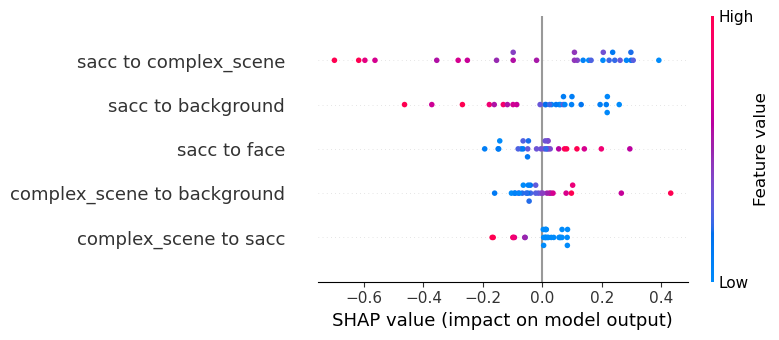

In [748]:
# featureofinterest = [1,2,3,4,6,9,10,12,18,24,25,26,27,30,31,32,33,34,35]
# feature_names = np.array(feature_names)[featureofinterest]
shap.summary_plot(shap_values, np.array(X_test, dtype="float64"), max_display=5, feature_names=feature_names, plot_type='dot')

In [757]:
shap_values[0]

.values =
array([ 0.29821429,  0.02440476,  0.00952381,  0.        , -0.09761905,
        0.01547619])

.base_values =
0.75

.data =
array([0.00824706, 0.00193016, 0.00391066, 0.        , 0.0010661 ,
       0.02665245])

In [763]:
feature_names

array(['sacc to complex_scene', 'sacc to background', 'sacc to face',
       'sacc to blink', 'complex_scene to sacc',
       'complex_scene to background', 'complex_scene to face',
       'complex_scene to blink', 'background to sacc',
       'background to complex_scene', 'background to face',
       'background to blink', 'face to sacc', 'face to complex_scene',
       'face to background', 'face to blink', 'blink to sacc',
       'blink to complex_scene', 'blink to background', 'blink to face'],
      dtype='<U30')

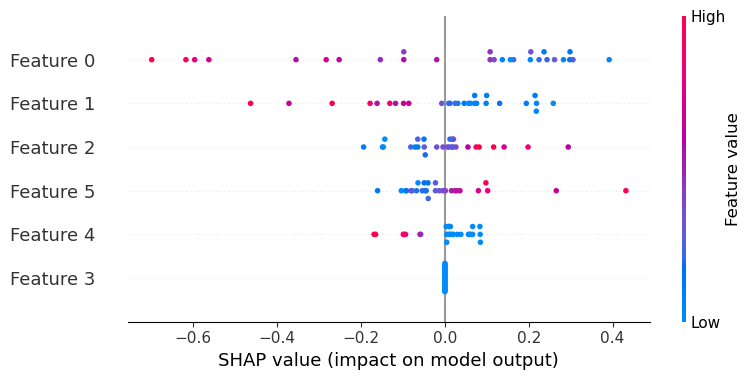

In [776]:
# Fits the explainer
explainer = shap.Explainer(model.predict, np.array(X_test, dtype="float64"))
# Calculates the SHAP values - It takes some time
shap_values = explainer(np.array(X_test, dtype="float64"))
# shap_values.feature_names = feature_names
shap.summary_plot(shap_values, np.array(X_test, dtype="float64"))
# shap.summary_plot(shap_values[0], np.array(X_test, dtype="float64"))

In [735]:
shap_values.shape

(28, 6)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


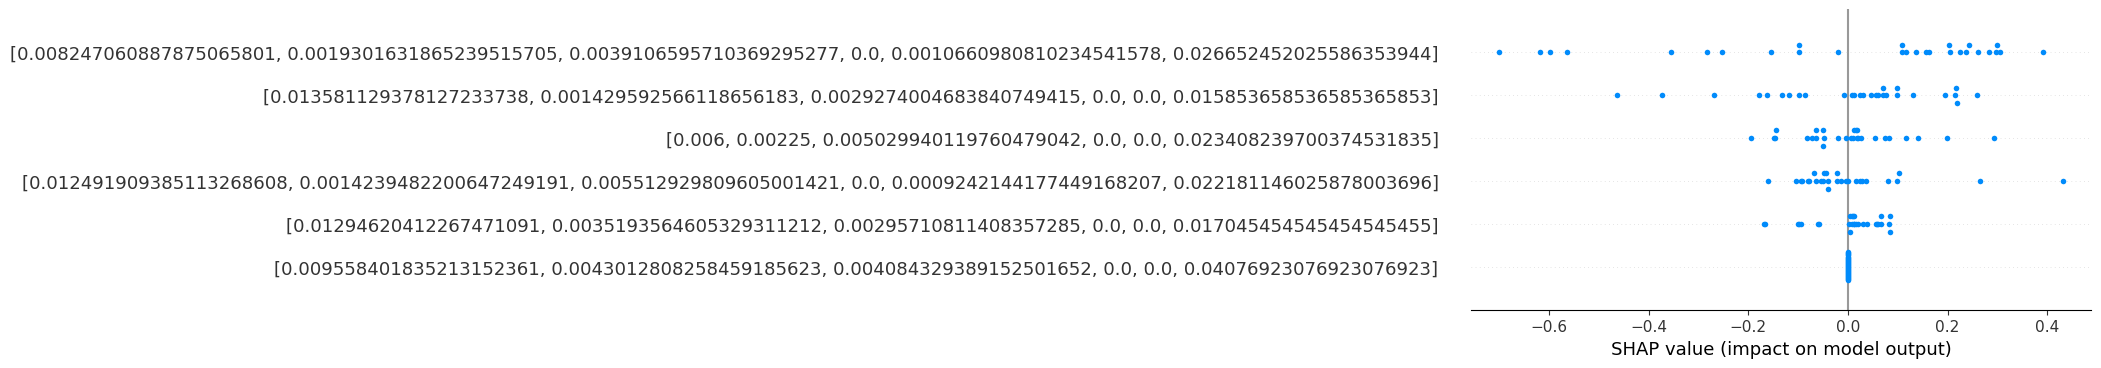

In [736]:
shap.summary_plot(shap_values, X_test)

# Testing Space

In [648]:
ctmc_cvi_models.keys()

dict_keys(['1044_4', '1023_2', '1047_3', '1056_1', '1053_3', '1039_1', '1046_2', '1043_4', '1020_4', '1039_4', '1046_3', '1047_1', '1022_4', '1027_2', '1050_3', '1043_1', '1026_1', '1034_3', '1028_3', '1052_3', '1031_4', '1028_4', '1046_4', '1042_1', '1013_4', '1028_2', '1048_1', '1019_3', '1046_1', '1017_4', '1023_3', '1039_3', '1040_1', '1042_2', '1049_1', '1010_4', '1040_4', '1051_1', '1034_2', '1039_2', '1048_2', '1031_2', '1045_4', '1050_1', '1043_3', '1018_3', '1031_1', '1018_4', '1037_4', '1020_3', '1054_1', '1042_4', '1048_3', '1024_1', '1033_1', '1035_3', '1034_1', '1027_4', '1028_1', '1051_2', '1042_3', '1013_3', '1047_2', '1023_1', '1022_3', '1010_3', '1027_1'])

In [649]:
ctmc_models.keys()

dict_keys(['1003_2', '1003_3', '1003_4', '1004_2', '1005_1', '1006_1', '1006_2', '1006_3', '1006_4', '1007_1', '1007_2', '1007_3', '1007_4', '1008_1', '1010_1', '1010_2', '1010_3', '1010_4', '1011_1', '1011_2', '1011_3', '1013_1', '1013_2', '1013_3', '1013_4', '1015_1', '1015_2', '1017_1', '1017_2', '1017_3', '1017_4', '1018_1', '1018_2', '1018_3', '1018_4', '1019_2', '1019_3', '1019_4', '1020_1', '1020_2', '1020_3', '1020_4', '1022_1', '1022_2', '1022_3', '1022_4', '1023_1', '1023_2', '1023_3', '1023_4', '1024_1', '1024_2', '1024_3', '1026_1', '1027_1', '1027_2', '1027_3', '1027_4', '1028_1', '1028_2', '1028_3', '1030_1', '1031_1', '1031_2', '1031_3', '1031_4', '1034_1', '1034_2', '1035_1', '1035_4', '1037_1', '1037_4', '1039_1', '1039_2', '1039_3', '1039_4', '1040_1', '1040_4', '1042_1', '1042_2', '1042_3', '1042_4', '1043_1', '1043_2', '1043_3', '1044_1', '1044_2', '1044_4', '1045_2', '1045_3', '1045_4', '1046_1', '1046_2', '1046_3', '1046_4', '1047_2', '1047_3', '1048_1', '1048_2',

In [650]:
(set(ctmc_cvi_models.keys()) & set(ctmc_models.keys()))

{'1010_3',
 '1010_4',
 '1013_3',
 '1013_4',
 '1017_4',
 '1018_3',
 '1018_4',
 '1019_3',
 '1020_3',
 '1020_4',
 '1022_3',
 '1022_4',
 '1023_1',
 '1023_2',
 '1023_3',
 '1024_1',
 '1026_1',
 '1027_1',
 '1027_2',
 '1027_4',
 '1028_1',
 '1028_2',
 '1028_3',
 '1031_1',
 '1031_2',
 '1031_4',
 '1034_1',
 '1034_2',
 '1037_4',
 '1039_1',
 '1039_2',
 '1039_3',
 '1039_4',
 '1040_1',
 '1040_4',
 '1042_1',
 '1042_2',
 '1042_3',
 '1042_4',
 '1043_1',
 '1043_3',
 '1044_4',
 '1045_4',
 '1046_1',
 '1046_2',
 '1046_3',
 '1046_4',
 '1047_2',
 '1047_3',
 '1048_1',
 '1048_2',
 '1048_3',
 '1049_1',
 '1050_1',
 '1050_3',
 '1051_1',
 '1051_2',
 '1052_3',
 '1053_3',
 '1054_1',
 '1056_1'}

In [651]:
ctmc_cvi_models['1010_3'].matrix

array([[0.        , 0.0053411 , 0.00273125, 0.        ],
       [0.00628426, 0.        , 0.        , 0.        ],
       [0.        , 0.02554028, 0.        , 0.        ],
       [0.00127443, 0.        , 0.00084962, 0.        ]], dtype=float128)

In [652]:
ctmc_models['1010_3'].matrix/12

array([[0.        , 0.01724138, 0.02011494, 0.01724138, 0.02873563,
        0.        ],
       [0.        , 0.        , 0.00018464, 0.        , 0.        ,
        0.        ],
       [0.        , 0.0005144 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00039683, 0.        , 0.        , 0.        ,
        0.        ],
       [0.0047619 , 0.00595238, 0.00238095, 0.00357143, 0.        ,
        0.        ],
       [0.02083333, 0.00694444, 0.00694444, 0.03472222, 0.01388889,
        0.        ]], dtype=float128)

In [706]:
from scipy.optimize import nnls
def get_rate_matrix(ctmc_model):
    matrix = ctmc_model.matrix.astype(np.float64)
    for i in range(len(matrix)):
        matrix[i][i] = np.sum(matrix[i])*(-1)
    return np.matrix.transpose(matrix)

def get_stationary_dis(ctmc_model):
    A = get_rate_matrix(ctmc_model)
    b = np.zeros((7,))
    A = np.vstack((A,np.ones(6)))
    b[6] = 1
    lsq = np.linalg.lstsq(A, b, rcond=None)
    return lsq[0].flatten()

In [ ]:
ctmc_models.keys()

In [713]:
cvikeys = []
ctrlkeys = []
for k in ctmc_models:
    if(int(k.split('_')[0]) > 2000):
        ctrlkeys.append(k)
    else:
        cvikeys.append(k)
filterByKey = lambda keys: {x: ctmc_models[x] for x in keys}
ctmc_cvi_models = filterByKey(cvikeys)
ctmc_ctrl_models = filterByKey(ctrlkeys)

In [715]:
ctmc_cvi_models.keys()

dict_keys(['1003_2', '1003_3', '1003_4', '1004_2', '1005_1', '1006_1', '1006_2', '1006_3', '1006_4', '1007_1', '1007_2', '1007_3', '1007_4', '1008_1', '1010_1', '1010_2', '1010_3', '1010_4', '1011_1', '1011_2', '1011_3', '1013_1', '1013_2', '1013_3', '1013_4', '1015_1', '1015_2', '1017_1', '1017_2', '1017_3', '1017_4', '1018_1', '1018_2', '1018_3', '1018_4', '1019_2', '1019_3', '1019_4', '1020_1', '1020_2', '1020_3', '1020_4', '1022_1', '1022_2', '1022_3', '1022_4', '1023_1', '1023_2', '1023_3', '1023_4', '1024_1', '1024_2', '1024_3', '1026_1', '1027_1', '1027_2', '1027_3', '1027_4', '1028_1', '1028_2', '1028_3', '1030_1', '1031_1', '1031_2', '1031_3', '1031_4', '1034_1', '1034_2', '1035_1', '1035_4', '1037_1', '1037_4', '1039_1', '1039_2', '1039_3', '1039_4', '1040_1', '1040_4', '1042_1', '1042_2', '1042_3', '1042_4', '1043_1', '1043_2', '1043_3', '1044_1', '1044_2', '1044_4', '1045_2', '1045_3', '1045_4', '1046_1', '1046_2', '1046_3', '1046_4', '1047_2', '1047_3', '1048_1', '1048_2',

In [716]:
ctrl_temp = []
cvi_temp = []

for key in ctmc_cvi_models:
    cvi_temp.append(get_stationary_dis(ctmc_cvi_models[key]))
for key in ctmc_ctrl_models:
    ctrl_temp.append(get_stationary_dis(ctmc_ctrl_models[key]))

In [720]:
cvi_temp[0]

array([ 1.05961933e-01,  5.26342121e-01,  6.80121657e-02,  2.99425009e-01,
        2.58771937e-04, -2.79752304e-16])

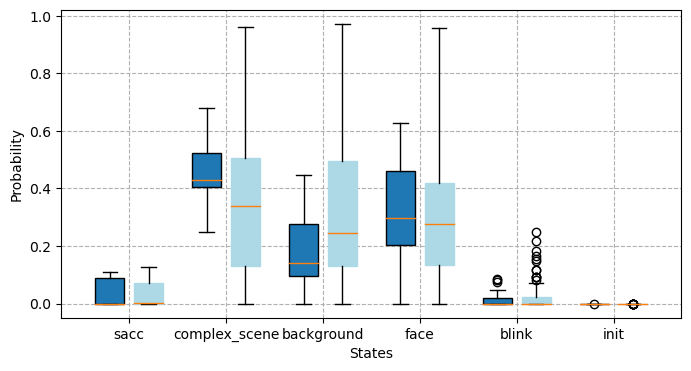

In [719]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (8, 4)
X = ['sacc','complex_scene','background', 'face', 'blink','init']
X_axis = np.arange(len(X)) 
c = 'lightblue'
# Creating plot
bp1 = plt.boxplot([np.row_stack(ctrl_temp)[:,i] for i in range(6)], widths=0.3, positions = X_axis - 0.2, patch_artist=True, notch=False, whis=2.5)
bp2 = plt.boxplot([np.row_stack(cvi_temp)[:,i] for i in range(6)], widths=0.3, positions = X_axis + 0.2, patch_artist=True, notch=False, whis=2.5,
                  boxprops=dict(facecolor=c, color=c))

plt.xticks(X_axis, X) 
plt.grid(linestyle='--')
# plt.legend(['Controls', 'CVIs'])
# plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Controls', 'CVIs'], loc='upper right')
plt.ylabel('Probability')
plt.xlabel('States')
# show plot
plt.show()